# Greedy training tutorial

In this tutorial you will learn the basics of contructing a greedy training workflow using romtools

https://pressio.github.io/rom-tools-and-workflows/romtools/workflows/greedy/run_greedy.html



In [23]:
#First, let's import the relavant modules:
import romtools
import numpy as np
from matplotlib import pyplot as plt
import sys
import os
sys.path.append('adr_1d/')
from adr_1d import advectionDiffusionProblem

In [4]:
#First, we will import the FOM model.
#Here, we will just use the advection diffusion FOM we setup in the external model tutorial 

from ipynb.fs.full.external_qoi_model import adrExternalRomToolsQoiModel
myFom = adrExternalRomToolsQoiModel()

# Now, let's setup our parameter space. We will use the parameter space we constructed in the parameter_space
from ipynb.fs.full.parameter_space import BasicParameterSpace
myParameterSpace = BasicParameterSpace()


In [5]:
# Now, we need to setup our ROM. For greedy, we need a QoIModelWithErrorEstimate.
# we haven't make this type of model in our tutorial series, and will do so now.

#As a starting point, let's import the ROM model we made in the model_builder tutorial

from ipynb.fs.full.model_builder import adrRom

#We now need to add a compute_qoi method and a compute_error_estimate_method:
class adrQoiRomWithErrorEstimate(adrRom):
    def compute_qoi(self, run_directory: str, parameter_sample: dict):
        # Note that compute_qoi is always called after run_model
        solution = np.load(run_directory + '/solution.npz')
        u = solution['u']
        x = solution['x']
        dx = x[1] - x[0] #we use a uniform grid
        ux_at_right_edge = (0. - u[-1])/dx
        return ux_at_right_edge

    # Now we will add a method for computing an error estimate.
    # As an error estimate, we will use the norm of the FOM residual evaluated about the ROM solution
    def compute_error_estimate(self, run_directory: str, parameter_sample: dict):
        rom_data = np.load(self.offline_directory_ + '/rom_data.npz')
        solution = np.load(run_directory + '/solution.npz')
        u = solution['u']
        residual = (parameter_sample['c']*rom_data['Ac'] - parameter_sample['nu']*rom_data['Ad'])@u - rom_data['f']
        residual_norm = np.linalg.norm(residual)
        return residual_norm

#Now we will construct a model_builder. We will use the one we initiated in the model_builder tutorial
from ipynb.fs.full.model_builder import AdrRomModelBuilder
myIntrusiveFom = advectionDiffusionProblem(nx=33)
myRomModelBuilder = AdrRomModelBuilder(myIntrusiveFom,adrQoiRomWithErrorEstimate)

In [18]:
#Now we can run the greedy workflow!
if __name__ == "__main__":
    greedy_work_dir = os.getcwd() + '/greedy_example/'
    tolerance = 1.e-6 #tolerance on greedy algorithm
    testing_sample_size = 10 #sample size on which to evaluate greedy ROM
    romtools.workflows.greedy.run_greedy(myFom,myRomModelBuilder,myParameterSpace,greedy_work_dir,
    	tolerance,testing_sample_size)


Greedy iteration # 0
Greedy iteration # 1
Greedy iteration # 2
Greedy iteration # 3
Greedy iteration # 4
Greedy iteration # 5
Greedy iteration # 6
Greedy iteration # 7
Greedy iteration # 8
Run converged, max approximate qoi error = 4.3477021339064117e-07


In [19]:
    #Let's check how some statistics for the workflow.
    #Greedy will save out a file called greedy_stats.npz in the work directory with information on convergence
    stats = np.load(greedy_work_dir + '/greedy_stats.npz')
    print("Stored values are: ", list(stats.keys()))

Stored values are:  ['max_error_indicators', 'qoi_errors', 'predicted_qoi_errors', 'training_samples', 'fom_time', 'rom_time', 'basis_time']


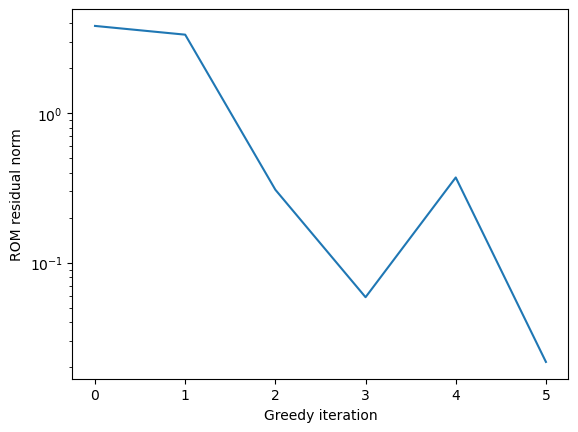

In [11]:
    #Let's look at a plot of the max_error_indicator vs iteration:
    plt.plot(stats['max_error_indicators'])
    plt.yscale('log')
    plt.xlabel(r'Greedy iteration')
    plt.ylabel(r'ROM residual norm')
    plt.show()

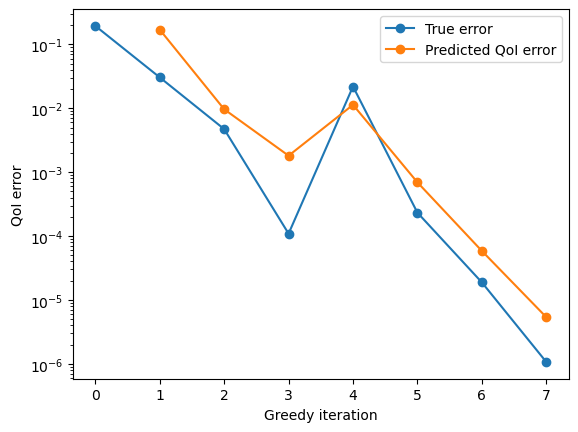

In [22]:
    #Now lets look at the "true QoI error" computed after each greedy iteration and compare it to our predicted QoI error
    # Note that the predicted QoI error is not tabulated at the first iteration
    iterations_for_predicted_errors = np.arange(1,stats['predicted_qoi_errors'].size+1)
    plt.plot(stats['qoi_errors'],'-o',label='True error')
    plt.plot(iterations_for_predicted_errors,stats['predicted_qoi_errors'],'-o',label='Predicted QoI error')
    plt.yscale('log')
    plt.xlabel(r'Greedy iteration')
    plt.ylabel(r'QoI error')
    plt.legend()
    plt.show()